In [1]:
from ase import Atoms
from ase.build import bulk
from ase.units import Ry, Bohr
from ase.calculators.abinit import Abinit
import os
import numpy as np

In [2]:
from ase.visualize.plot import plot_atoms

In [3]:
from matplotlib import pylab as plt

In [4]:
from ase.visualize import view

In [5]:
# Konfiguracja programu abinit
os.environ['ASE_ABINIT_COMMAND']='abinit < PREFIX.files > PREFIX.log'
os.environ['ABINIT_PP_PATH']='abinit_psp/GGA_FHI/:abinit_psp/LDA_FHI/:abinit_psp/LDA_PAW/:abinit_psp/GGA_PAW/'

In [6]:
#diam = bulk(name='C',crystalstructure='diamond',a=4)
H2 = Atoms("H2", positions=[(0,0,0),(1,0,0)], cell=[10, 10, 10])

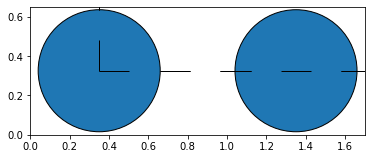

In [7]:
plot_atoms(H2, colors=2*['C0'], show_unit_cell=1);

In [16]:
calc = Abinit(label='h2',
              nbands=8,  
              ecut=10 * Ry,  # !! 
              kpts=[1, 1, 1],  # !!
              chksymbreak=0,
              )


calc.set(toldfe=1.0e-3)  # !!

{'toldfe': 0.001}

In [17]:
H2.set_calculator(calc)

In [18]:
H2.get_potential_energy()

-28.946864721091032

In [19]:
EvsD = []
FvsD = []
for d in np.linspace(1, 2, 7):
    H2.set_positions([(0,0,0),(0,0,d*Bohr)])
    EvsD.append([d,H2.get_potential_energy()])
    FvsD.append([d,H2.get_forces()])
    print(d, EvsD[-1])

1.0 [1.0, -27.40108152461274]
1.1666666666666667 [1.1666666666666667, -28.88110920906284]
1.3333333333333333 [1.3333333333333333, -29.498091936732212]
1.5 [1.5, -29.634166960481497]
1.6666666666666665 [1.6666666666666665, -29.511389053878872]
1.8333333333333333 [1.8333333333333333, -29.258274741373143]
2.0 [2.0, -28.946864721091032]


In [20]:
EvsD = np.array(EvsD).T

In [21]:
fit = np.polyfit(EvsD[0]*Bohr, EvsD[1], 4)

In [22]:
mpos = [np.real(r) for r in np.roots(fit[:-1] * np.arange(4,0,-1)) if abs(np.imag(r))<1e-3][0]

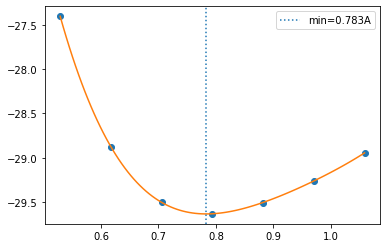

In [23]:
plt.plot(EvsD[0]*Bohr, EvsD[1], "o")
d = np.linspace(1*Bohr,2*Bohr,100)
plt.plot(d, np.polyval(fit, d), "-")
plt.axvline(mpos, ls=':', label=f'min={mpos:.3f}A')
plt.legend();